In [1]:
import os
import glob
import numpy as np
import torch.nn as nn
import torch
import cv2
from PIL import Image
from skimage import exposure
import matplotlib.pyplot as plt
from utils import *
import lpips




In [2]:
R_path=glob.glob("data/processed/R/*.jpg")
V_path=glob.glob("data/processed/V/*.jpg")


# histogram equalization

In [20]:
for path in R_path:
    im=cv2.imread(path,cv2.COLOR_RGB2GRAY)
    im=Histogram_equalization(im[:,:,0])
    cv2.imwrite(os.path.join("./generated_images/Histogram_equalization",path[-12:]),im)
    
for path in V_path:
    im=cv2.imread(path,cv2.COLOR_RGB2GRAY)
    im=Histogram_equalization(im[:,:,0])
    cv2.imwrite(os.path.join("./generated_images/Histogram_equalization",path[-12:]),im)
    

In [4]:
R_path[0][-12:]

'R/R02085.jpg'

# histogram matching

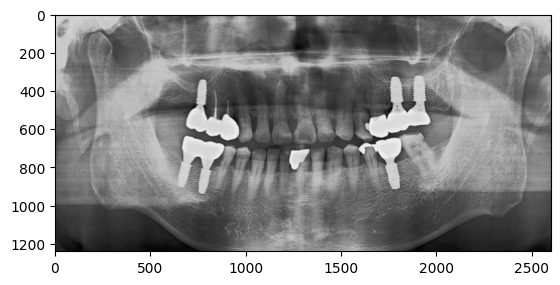

In [5]:
#im=Image.open(R_path[0]).convert("L")
im=cv2.imread(R_path[0],cv2.IMREAD_GRAYSCALE)
im2=cv2.imread(V_path[0],cv2.IMREAD_GRAYSCALE)
plt.imshow(histogram_matching(im,im2),cmap='gray')

## Histogram matching Mean

In [26]:
hist=np.array([0]*256)

for path in V_path:
    im=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    hist+=get_histogram(im)

hist=hist/len(V_path)
    

In [25]:
im=cv2.imread(V_path[0],cv2.IMREAD_GRAYSCALE)
im_hist=get_histogram(im).shape
hist=np.array([0]*256)
hist.shape

(256,)

In [6]:
hists=[]
im_origin=cv2.imread(V_path[0],cv2.IMREAD_GRAYSCALE)
hist_origin=cv2.calcHist([im_origin],[0],None,[256],[0,256]).astype('int32')

def cos_sim(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
     
for i,path in enumerate(R_path[:500]):
    hist=cv2.calcHist([cv2.imread(path,cv2.IMREAD_GRAYSCALE)],[0],None,[256],[0,256]).astype('int32')
    hists.append(hist.squeeze())
ret=[]
for i,histogram in enumerate(hists):
    ret.append(cos_sim(hists[0],histogram))

print(ret)

KeyboardInterrupt: 

# LPIPS Histogram matching

In [14]:
from pathlib import Path
from itertools import chain
from torch.utils import data
from torchvision import transforms


def listdir(dname):
    # 해당 경로 하위의 모든 image파일 경로 
    fnames = list(chain(*[list(Path(dname).rglob('*.' + ext))
                          for ext in ['png', 'jpg', 'jpeg', 'JPG']]))
    return fnames

class DefaultDataset(data.Dataset):
    def __init__(self, root, resize=256):
        self.samples=listdir(root)
        self.targets = None
        self.resize=resize
        if self.resize:
            self.transform=transforms.Compose([
                transforms.Resize([self.resize,self.resize]),
                transforms.ToTensor(),
                ])

    def __getitem__(self, index):
        
        fname = self.samples[index]
        img = Image.open(fname).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img,index
    
    def __len__(self):

        return len(self.samples)

def get_train_loader(root,target_root,batchsize=16,num_workers=4,shuffle=False):
    
    dataset=DefaultDataset(root)
    target_dataset=DefaultDataset(target_root)

    loader=data.DataLoader(dataset=dataset,
                           batch_size=1,
                           num_workers=num_workers,
                           shuffle=shuffle
                          )
    target_loader=data.DataLoader(dataset=target_dataset,
                                  batch_size=batchsize,
                                  num_workers=num_workers,
                                  shuffle=shuffle
                                  )
    
    return loader,target_loader

loader,target_loader=get_train_loader('./data/processed/R','./data/processed/V/')
loss_fn_alex=lpips.LPIPS(net='vgg')
GPU_NUM = 5
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

loss_fn_alex.cuda()
a=0
print(len(loader))
loader_path=list(map(lambda x:os.path.basename(x),np.array(loader.dataset.samples)))
target_path=list(map(lambda x:os.path.basename(x),np.array(target_loader.dataset.samples)))
for img,index in loader:
    ds=100,0
    img_path=loader_path[index]
    
    for target in target_loader:
        d=loss_fn_alex(img.cuda(),target[0].cuda()).squeeze()
        for i in range(len(d)):
            if d[i]<=ds[0]:
                ds=d[i],target_path[target[1][i]]
        print(ds)
        break
        
    matched=histogram_matching(cv2.imread(os.path.join('./data/processed/R',img_path),cv2.IMREAD_GRAYSCALE),
                               cv2.imread(os.path.join('./data/processed/V',ds[1]),cv2.IMREAD_GRAYSCALE))

    
    
    cv2.imwrite(os.path.join("./generated_images/LPIPS_Histogram_matching",img_path),matched)



Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/poong/yes/envs/jaepoong/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/poong/yes/envs/jaepoong/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/poong/yes/envs/jaepoong/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
4014
(tensor(0.4469, device='cuda:5', grad_fn=<SelectBackward0>), 'V00546.jpg')
(tensor(0.4255, device='cuda:5', grad_fn=<SelectBackward0>), 'V03480.jpg')
(tensor(0.4638, device='cuda:5', grad_fn=<SelectBackward0>), 'V00506.jpg')
(tensor(0.4346, device='cuda:5', grad_fn=<SelectBackward0>), 'V00506.jpg')
(tensor(0.4346, device='cuda:5', grad_fn=<SelectBackward0>), 'V00546.jpg')
(tensor(0.4327, device='cuda:5', grad_fn=<SelectBackward0>), 'V03374.jpg')
(tensor(0.4773, device='cuda:5', grad_fn=<SelectBackward0>), 'V03164.jpg')
(tensor(0.4358, device='cuda:5', grad_fn=<SelectBackward0>), 'V00506.jpg')
(tensor(0.4171, device='cuda:5', grad_fn=<SelectBackward0>), 'V03480.jpg')
(tensor(0.4212, device='cuda:5', grad_fn=<SelectBackward0>), 'V03480.jpg')
(tensor(0.4474, device='cuda:5', grad_fn=<SelectBackward0>), 'V00506.jpg')
(tensor(0.4768, device='cuda:5', grad_fn=<SelectBackward0>), 'V03

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3427c61e50>
Traceback (most recent call last):
  File "/home/poong/yes/envs/jaepoong/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/poong/yes/envs/jaepoong/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/poong/yes/envs/jaepoong/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/poong/yes/envs/jaepoong/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/home/poong/yes/envs/jaepoong/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/poong/yes/envs/jaepoong/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.po

(tensor(0.4350, device='cuda:5', grad_fn=<SelectBackward0>), 'V03164.jpg')
(tensor(0.4069, device='cuda:5', grad_fn=<SelectBackward0>), 'V00821.jpg')
(tensor(0.4176, device='cuda:5', grad_fn=<SelectBackward0>), 'V00506.jpg')
(tensor(0.4585, device='cuda:5', grad_fn=<SelectBackward0>), 'V01714.jpg')
(tensor(0.4142, device='cuda:5', grad_fn=<SelectBackward0>), 'V03480.jpg')
(tensor(0.4702, device='cuda:5', grad_fn=<SelectBackward0>), 'V03164.jpg')
(tensor(0.4294, device='cuda:5', grad_fn=<SelectBackward0>), 'V00821.jpg')
(tensor(0.4159, device='cuda:5', grad_fn=<SelectBackward0>), 'V03374.jpg')


In [9]:
os.path.join('./data/processed/R',target_path[target[1][1]]),img_path

('./data/processed/R/V02990.jpg', 'R02085.jpg')

In [27]:
list(map(lambda x:os.path.basename(x),np.array(loader.dataset.samples)))[1]

'R00365.jpg'

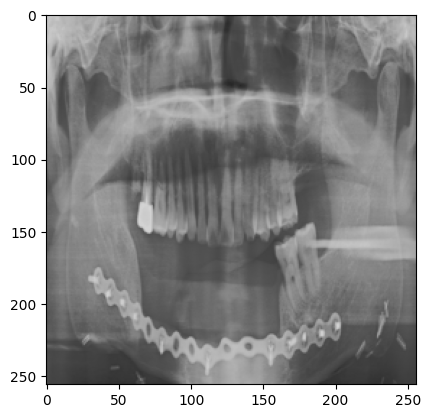

In [22]:
plt.imshow(matched)

In [21]:
from skimage import exposure
import matplotlib.pyplot as plt
from torchvision import transforms


src=cv2.resize(cv2.imread(R_path[0]),(256,256))
src=np.array([src,src])
src=np.transpose(src,(0,3,1,2))
ref=cv2.resize(cv2.imread(V_path[5]),(256,256))
ref=np.array([ref,ref])
ref=np.transpose(ref,(0,3,1,2))

#mathced=exposure.match_histograms(src,ref)

In [12]:
from utils import *

In [24]:
import lpips
loss_fn_alex=lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/poong/yes/envs/jaepoong/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


In [25]:
d=loss_fn_alex(torch.tensor(src),torch.tensor(ref))

In [30]:
d.squeeze()

tensor([0.2093, 0.2093], grad_fn=<SqueezeBackward0>)

In [5]:

matched=histogram_matching(cv2.imread(R_path[0],cv2.IMREAD_GRAYSCALE),cv2.imread(R_path[0],cv2.IMREAD_GRAYSCALE))

In [39]:
np.array(torch.tensor(src)[0]).transpose((1,2,0)).shape,cv2.resize(cv2.imread(R_path[0]),(256,256)).shape


((256, 256, 3), (256, 256, 3))

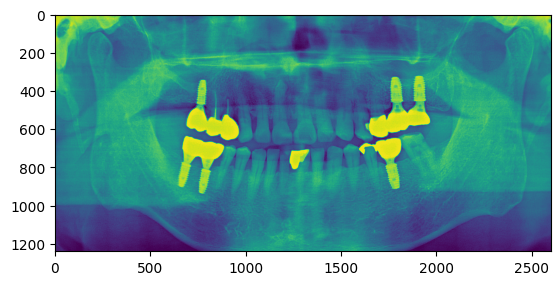

In [6]:
plt.imshow(matched)

In [9]:
torch.tensor(R_path[0])

TypeError: new(): invalid data type 'str'

In [10]:
R_path[0]

'data/processed/R/R02085.jpg'